# ch 16_5 ARIMA

이번 챕터에서는 본격적으로 시계열 예측 모델들에 대해서 배웁니다. 그 중에서도 ARIMA는 가장 기본적인 시계열 예측 모델입니다.

In [2]:
import warnings

warnings.filterwarnings(action='ignore')

## 데이터 셋 준비

과적합 여부 파악과 성능 평가를 위해 특정 시점을 기준으로 train과 test 셋을 나누겠습니다.

In [3]:
from utils import load_air_passengers

train_df, test_df = load_air_passengers()

<Axes: xlabel='Month'>

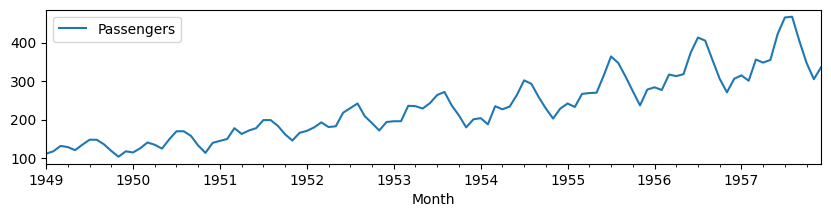

In [4]:
train_df.plot(figsize=(10, 2))

<Axes: xlabel='Month'>

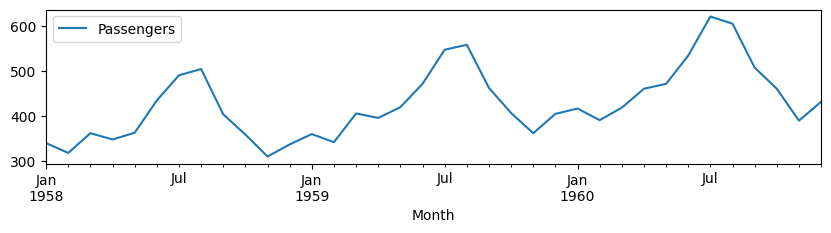

In [5]:
test_df.plot(figsize=(10, 2))

## ARIMA

ARIMA 모델은 가장 기본적인 시계열 예측 모델이며 크게 세가지 구성 요소로 이루어져 있습니다. 

- AR(Auto Regression): 현재 관측값과 이전 기간의 관측값 사이의 종속 관계를 활용하는 회귀 모델입니다.
- I(Integration):  시계열을 고정시키기 위해 관측치 차분을 사용합니다. 미분은 시계열의 현재 값에서 이전 값 d 횟수를 빼는 것을 포함합니다.
- MA(Moving Average): 잔차 오차와 관측치 간의 종속성을 사용하는 모델입니다. 이동 평균 성분은 모델의 오차를 이전 오차 항의 조합으로 나타냅니다.

ARIMA 모델을 학습시키기 위해서는 p, d, q 세가지 파라미터를 결정해야 하며, 이를 위해선 각 구성 요소들이 어떻게 동작하는지 이해해야 합니다.

### Auto Regressive

이전 시점의 값들을 feature로 사용하여 다음에 올 값을 예측하는 회귀 모델입니다. 스스로를 feature로 사용하기 때문에 auto regressive 모델이라고 부릅니다. 

$$Y_{t}=\alpha+\beta_{1}Y_{t-1}+\beta_{t-2}+...+\beta_{p}Y_{t-p}+\epsilon_{t}$$

여기서 몇번째 lag 까지를 회귀식에 포함할 지를 의미하는 p가 ARIMA 모델을 학습시키기 위해 필요한 첫번째 파라미터입니다.

간단하게 AR 모델을 학습시켜보고, 시각화해보겠습니다.

In [6]:
from statsmodels.tsa.ar_model import AutoReg 

ar_4_model = AutoReg(train_df["Passengers"], lags=4).fit()
ar_12_model = AutoReg(train_df["Passengers"], lags=12).fit()

/Users/user/miniconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/user/miniconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [7]:
ar_4_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:             Passengers   No. Observations:                  108
Model:                     AutoReg(4)   Log Likelihood                -477.640
Method:               Conditional MLE   S.D. of innovations             23.897
Date:                Mon, 31 Jul 2023   AIC                            967.280
Time:                        15:53:22   BIC                            983.147
Sample:                    05-01-1949   HQIC                           973.708
                         - 12-01-1957                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            12.3043      7.155      1.720      0.085      -1.719      26.328
Passengers.L1     1.3051      0.099     13.210      0.000       1.111       1.499
Passengers.L2    -0.5453      0.163     -3.338      0.001      -0.866      -0.225
Passengers.L3     0.1201      0.165      0.730      0.466      -0.203       0.443
Passengers.L4     0.0761      0.102      0.744      0.457      -0.125       0.277
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0492           -0.0000j            1.0492           -0.0000
AR.2            0.8458           -1.4776j            1.7026           -0.1673
AR.3            0.8458           +1.4776j            1.7026            0.1673
AR.4           -4.3188           -0.0000j            4.3188           -0.5000
-----------------------------------------------------------------------------
"""

In [8]:
train_df["AR 4"] = ar_4_model.predict()
train_df["AR 12"] = ar_12_model.predict()

<Axes: xlabel='Month'>

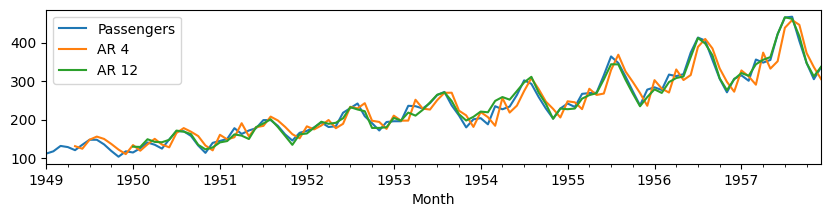

In [9]:
train_df.plot(figsize=(10, 2))

In [10]:
test_df["AR 4"] = ar_4_model.forecast(steps=len(test_df))
test_df["AR 12"] = ar_12_model.forecast(steps=len(test_df))

<Axes: xlabel='Month'>

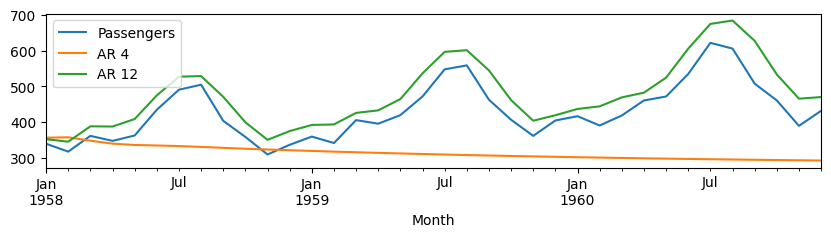

In [11]:
test_df.plot(figsize=(10, 2))

예측 결과가 얼마나 정확한지 오차를 측정해보겠습니다.

In [14]:
from utils import calculate_rmse

calculate_rmse(test_df, "Passengers", "AR 4")
calculate_rmse(test_df, "Passengers", "AR 12")

AR 4 RMSE: 144.19119770397384
AR 12 RMSE: 51.56756034519986


### Moving Average

ARIMA 모델에서 등장하는 moving average는 이전에 직접 구해보았던 이동 평균과는 다른 개념입니다. 이는 auto regressive 모델의 예측값과 실제 값 사이의 오차를 feature로 사용하는 회귀 모델입니다. 앞서 학습시킨 auto regressive의 예측값과 실제 값 사이에 오차항을 확인해보겠습니다.

In [15]:
train_df["AR 4 err"] = train_df["Passengers"] - train_df["AR 4"]
train_df["AR 12 err"] = train_df["Passengers"] - train_df["AR 12"]

<Axes: xlabel='Month'>

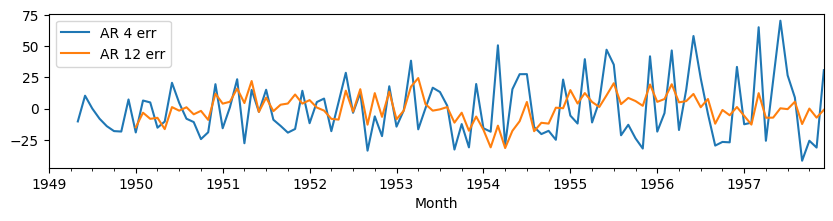

In [16]:
train_df[["AR 4 err", "AR 12 err"]].plot(figsize=(10, 2))

Moving Average는 AR 모델의 오차항들을 feature로 사용해서 예측을 하는 모델입니다. 이 때, 현재 시점으로부터 몇번째 전의 오차항까지 볼 것인지를 결정하는 파라미터가 q입니다. 

$$Y_{t}=\alpha+\epsilon_{t}+\phi_{1}\epsilon_{t-1}+\phi_{2}\epsilon_{t-2}+...+\phi_{q}\epsilon_{t-q}$$

$$\epsilon_{t}=Y_{t}-\hat{Y}_{t}$$

Moving Average 모델은 Auto Regressive 모델을 필요로 하기에, 단독으로 사용되지 않고, ARMA나 ARIMA 모델에서 AR 모델과 결합된 형태로 사용됩니다.

### ARMA

ARMA 모델은 AR 모델과 MA 모델을 단순 결합시킨 모델입니다. 이는 과거 시점의 데이터와 auto regressive 모델의 오차항을 독립 변수로 사용하는 회귀 모델입니다. 수식으로 표현하면 아래와 같습니다.

$$Y_{t}=\alpha+\beta_{1}Y_{t-1}+\beta_{t-2}Y_{t-2}+...+\beta_{p}Y_{t-p}+\epsilon_{t} +\phi_{1}\epsilon_{t-1}+\phi_{2}\epsilon_{t-2}+...+\phi_{q}\epsilon_{t-q}$$ 

이는 statsmodels에서 별도로 클래스로 제공하는 것은 없고, ARIMA 모델 생성시에 전달하는 차분 파라미터 d를 0으로 설정하면 학습시킬 수 있습니다.

### ARIMA

드디어 오늘의 주인공 ARIMA입니다. ARIMA는 차분을 적용하여 정상성을 확보한 데이터에 ARMA 모델을 학습시킨 모델입니다.

- AR: auto regressive (p)
- I: integrated (d)
- MA: Moving Average (q)

ARIMA 모델을 학습시키기 위해서는 p, q, d 세 파라미터가 필요합니다. 

- p: auto regressive 모델이 몇 lag 까지를 모델에 포함시킬 것인가
- d: 차분을 몇번 적용할 것인가
- q: moving average 모델이 몇 lag 까지를 모델에 포함시킬 것인가

여기서는 간단하게 임의의 파라미터를 지정해서 ARIMA를 학습시켜보고 결과를 시각화해보겠습니다.

In [17]:
from statsmodels.tsa.arima.model import ARIMA

arima_4_model = ARIMA(train_df["Passengers"], order=(4, 1, 2)).fit()
arima_12_model = ARIMA(train_df["Passengers"], order=(12, 1, 2)).fit()

/Users/user/miniconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/user/miniconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/user/miniconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/user/miniconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/user/miniconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provid

In [18]:
arima_4_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Passengers   No. Observations:                  108
Model:                 ARIMA(4, 1, 2)   Log Likelihood                -482.186
Date:                Mon, 31 Jul 2023   AIC                            978.372
Time:                        15:53:36   BIC                            997.082
Sample:                    01-01-1949   HQIC                           985.957
                         - 12-01-1957                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1669      0.148      1.130      0.258      -0.123       0.456
ar.L2          0.3618      0.146      2.485      0.013       0.076       0.647
ar.L3         -0.2545      0.107     -2.389      0.017      -0.463      -0.046
ar.L4         -0.1775      0.139     -1.276      0.202      -0.450       0.095
ma.L1          0.1337      0.136      0.982      0.326      -0.133       0.401
ma.L2         -0.7175      0.149     -4.828      0.000      -1.009      -0.426
sigma2       474.1870     80.964      5.857      0.000     315.500     632.874
===================================================================================
Ljung-Box (L1) (Q):                   0.41   Jarque-Bera (JB):                 5.54
Prob(Q):                              0.52   Prob(JB):                         0.06
Heteroskedasticity (H):               4.51   Skew:                             0.49
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [19]:
train_df["ARIMA 4"] = arima_4_model.predict()
train_df["ARIMA 12"] = arima_12_model.predict()

<Axes: xlabel='Month'>

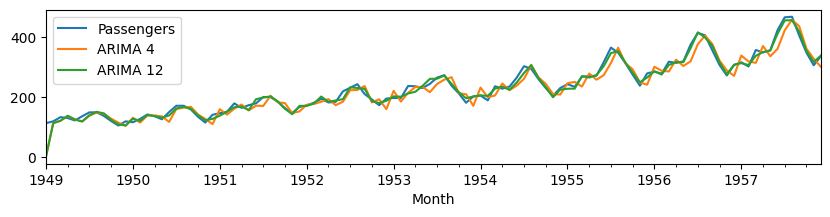

In [20]:
train_df[["Passengers", "ARIMA 4", "ARIMA 12"]].plot(figsize=(10, 2))

In [21]:
test_df["ARIMA 4"] = arima_4_model.forecast(steps=len(test_df))
test_df["ARIMA 12"] = arima_12_model.forecast(steps=len(test_df))

<Axes: xlabel='Month'>

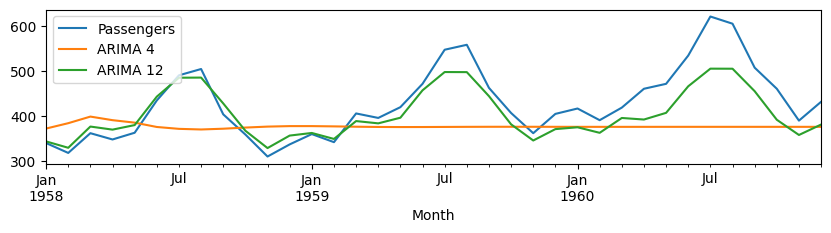

In [22]:
test_df[["Passengers", "ARIMA 4", "ARIMA 12"]].plot(figsize=(10, 2))

AR 모델과 ARIMA 모델의 성능을 측정해보겠습니다.

In [24]:
calculate_rmse(test_df, "Passengers", "AR 4")
calculate_rmse(test_df, "Passengers", "AR 12")
calculate_rmse(test_df, "Passengers", "ARIMA 4")
calculate_rmse(test_df, "Passengers", "ARIMA 12")

AR 4 RMSE: 144.19119770397384
AR 12 RMSE: 51.56756034519986
ARIMA 4 RMSE: 95.08986095722304
ARIMA 12 RMSE: 42.21961035865734


## 정리

이번 챕터에서는 기본적인 시계열 예측 모델인 ARIMA에 대해서 배워보았습니다. 그리고 ARIMA 모델을 학습시키기 위해서 필요한 파라미터 p, d, q에 대해서 알아보았고, 임의의 파라미터를 지정해서 모델을 학습시키고 결과를 확인해보았습니다. 다음 챕터에서는 ACF와 PACF를 이용해서 p, d, q 각 파라미터를 선택하는 방법에 대해서 알아보겠습니다.